# Our first RNN
Generic RNN for RNA sequence.

First goal.
Input sequence of K-mer frequencies, output binary classifier: protein-coding or non-coding.
Try to beat the DNN that we trained previously. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow import keras
tf.keras.backend.set_floatx('float64')

# Split into train/test stratified by sequence length.
def sizebin(df):
    return pd.cut(df["seqlen"],
                              bins=[0,1000,2000,4000,8000,16000,np.inf],
                              labels=[0,1,2,3,4,5])

In [2]:
nc3 = pd.read_csv ('ncRNA.3mer.features.csv')
pc3 = pd.read_csv ('pcRNA.3mer.features.csv')
nc3['class']=0
pc3['class']=1
rna3mer=pd.concat((nc3,pc3),axis=0)
bin_labels= sizebin(rna3mer)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=37863)
for train_index,test_index in splitter.split(rna3mer,bin_labels):
    train_set = rna3mer.iloc[train_index]
    test_set =  rna3mer.iloc[test_index]
y_train_all=  train_set[['class']].copy()
X_train_all=  train_set.div(train_set['seqlen'],axis=0)
X_train_all=  X_train_all.drop(columns=['class','seqnum','seqlen'])
y_test=   test_set[['class']].copy()
X_test=   test_set.div(test_set['seqlen'],axis=0)
X_test=   X_test.drop(columns=['class','seqnum','seqlen'])
X_train,y_train=X_train_all[:25000],y_train_all[:25000]
X_valid,y_valid=X_train_all[25000:],y_train_all[25000:]
# Convert pandas data frames to numpy arrays so we can use the reshape function.
# If pandas has reshape, I can't find it.
# Consider reading the data into numpy arrays in the first place.
# The first dimesion is batch size. Use -1 for unknown. Will it use batch=25K?
X_train = X_train.to_numpy().reshape(-1,25000,64)
y_train = y_train.to_numpy().reshape(-1,25000,1)
X_valid = X_valid.to_numpy().reshape(-1,5290,64)
y_valid = y_valid.to_numpy().reshape(-1,5290,1)
X_valid.shape

(1, 5290, 64)

In [3]:
# Input to SimpleRNN is 3D tensor: [batch size, time steps, dimensionality]
# batch size = b = between 1 and 25K
# time steps = L = length of sequences in this batch
# dimensionality = d = num features

# For us d=64.
# L has to be uniform for one whole batch. Some poeple zero-pad each sequence.
# Another choice is to set L=None and b=1 but this will be slow to train.
# We'll try this first.

# Long sequences can be split into subsequences of one batch. Set stateful=True
# https://keras.io/guides/working_with_rnns/

In [4]:
seq_len=None  # variable
input_features=64
# Consider using return_sequences = True at intermediate layers
# Consider using BatchNormalization
# Consider random initialization
rnn1 = keras.models.Sequential([
    keras.layers.SimpleRNN(64,  # match input 
                           return_sequences=True, input_shape=[seq_len,input_features]),
    keras.layers.SimpleRNN(1), # match output
])
bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
rnn1.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
history = rnn1.fit(X_train,y_train,epochs=5,validation_data=(X_valid,y_valid))
# This is really slow. We need a GPU.
# What does 1/1 mean? Is it learning on one sequence or one whole batch?
# How can we examine the weights to be sure it is learning?

Epoch 1/5
1/1 [==============================] - 1s 899ms/step - loss: 8.2363 - accuracy: 0.4660 - val_loss: 8.2023 - val_accuracy: 0.4682
Epoch 2/5
1/1 [==============================] - 0s 430ms/step - loss: 8.2363 - accuracy: 0.4660 - val_loss: 8.2023 - val_accuracy: 0.4682
Epoch 3/5
1/1 [==============================] - 0s 399ms/step - loss: 8.2363 - accuracy: 0.4660 - val_loss: 8.2023 - val_accuracy: 0.4682
Epoch 4/5
1/1 [==============================] - 0s 473ms/step - loss: 8.2363 - accuracy: 0.4660 - val_loss: 8.2023 - val_accuracy: 0.4682
Epoch 5/5
1/1 [==============================] - 0s 409ms/step - loss: 8.2363 - accuracy: 0.4660 - val_loss: 8.2023 - val_accuracy: 0.4682


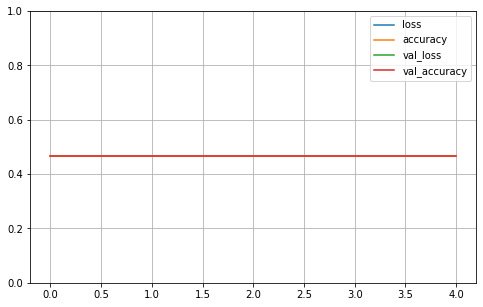

In [5]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

So far, accuracy is slightly better than guessing.

This is nonsense. 
We are feeding 64 K-mer frequencies per RNA.
We need to feed each RNA as a time series of K-mers.
Using 1-hot encoding for K-mers makes no sense except for K=1.
Use word2vec for consecutive overlapping K-mers.